##  Kỹ thuật xử lý Outlier


Outlier là một điểm dữ liệu khác biệt rất lớn so với dữ liệu còn lại. “Outlier là một quan sát sai lệch rất nhiều so với các quan sát khác để làm dấy lên nghi ngờ rằng nó được tạo ra bởi một cơ chế khác”. [D. Hawkins. Identification of Outliers, Chapman and Hall , 1980].

Các yếu tố thống kê như giá trị trung bình và phương sai rất dễ bị ảnh hưởng bởi outlier. Ngoài ra, **một số mô hình học máy nhạy với các outlier** có thể làm giảm chất lượng của chúng. Do đó, chúng ta thường loại bỏ outlier khỏi các biến tùy thuộc vào thuật toán mà chúng ta muốn huấn luyện.

Chúng ta đã thảo luận cách xác định outlier và trong phần này, chúng ta sẽ bàn về cách xử lý chúng để huấn luyện các mô hình học máy.


## Làm thế nào để tiền xử lý outlier?

- Trimming (Cắt tỉa): loại bỏ các outlier khỏi tập dữ liệu.
- Coi các outlier là dữ liệu bị khuyết và tiến hành với bất kỳ kỹ thuật gán dữ liệu bị khuyết nào.
- Rời rạc hóa: outlier được thay thế trong các border bin cùng với các giá trị cao hoặc thấp hơn của phân phối.
- Censoring (Kiểm duyệt): giới hạn phân phối biến ở giá trị max/min.

**Censoring** cũng được biết đến như:

- top/bottom coding
- windsorisation
- capping


## Censoring/Capping.

**Censoring (Kiểm duyệt)** hoặc **Capping (Giới hạn)** là giới hạn max/min của phân phối tại một giá trị bất kỳ. Nói cách khác, những giá trị lớn hơn hoặc nhỏ hơn các giá trị được xác định tùy ý đều được **kiểm duyệt**.

Capping có thể thực hiện ở cả 2 đầu hoặc 1 đầu phân phối còn tùy thuộc vào biến và người dùng.

Xem ví dụ về capping được sử dụng ở công ty tài chính trong phần diễn thuyết tại [PyData](https://www.youtube.com/watch?v=KHGGlozsRtA).

Các số để giới hạn phân phối có thể xác định:

- tùy ý
- sử dụng quy tắc tiệm cận IQR
- sử dụng phép xấp xỉ Gauss
- sử dụng quantile


### Ưu điểm

- không loại bỏ dữ liệu

### Hạn chế

- làm sai lệch các phân phối của biến
- làm sai lệch mối quan hệ giữa các biến


## Trong bản mô phỏng này

Chúng ta sẽ thực hiện capping với:

- Dataset Quy tắc tiệm cận IQR sử dụng tập dữ liệu Boston House.
- Phép xấp xỉ Gauss sử dụng tập dữ liệu Boston House.
- Quantile sử dụng tập dữ liệu Boston House.
- Các giá trị bất kỳ sử dụng tập dữ liệu Titanic.

## Quan trọng

Khi thực hiện capping, chúng ta thường giới hạn cả tập huấn luyện và tập kiểm tra. Cần nhớ rằng các giá trị giới hạn PHẢI được lấy từ tập huấn luyện, rồi dùng các giá trị tương tự đó để giới hạn các biến trong tập kiểm tra.

Chúng ta sẽ không thực hiện điều đó trong mô phỏng này nhưng hãy ghi nhớ khi thiết lập quy trình.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# cho biểu đồ Q-Q 
import scipy.stats as stats

# tập dữ liệu boston house cho mô phỏng
from sklearn.datasets import load_boston

from feature_engine.outliers import Winsorizer
from feature_engine.outliers import ArbitraryOutlierCapper

In [2]:
# load dữ liệu giá nhà ở Boston

# load tập dữ liệu boston từ sklearn
boston_dataset = load_boston()

# tạo một dataframe với các biến độc lập
# chúng ta sẽ chỉ sử dụng 3 trong tổng số các biến cho mô phỏng này

boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]

# thêm mục tiêu
boston['MEDV'] = boston_dataset.target

boston.head()

,RM,LSTAT,CRIM,MEDV
0,6.575,4.98,0.00632,24.0
1,6.421,9.14,0.02731,21.6
2,7.185,4.03,0.02729,34.7
3,6.998,2.94,0.03237,33.4
4,7.147,5.33,0.06905,36.2


In [3]:
# hàm tạo biểu đồ tần suất, biểu đồ Q-Q và
# biểu đồ hộp đã học trước đó


def diagnostic_plots(df, variable):
    # hàm nhận dataframe (df) và
    # biến cần quan tâm làm đối số

    # xác định kích thước figure
    plt.figure(figsize=(16, 4))

    # biểu đồ tần suất
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # biểu đồ Q-Q
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # biểu đồ hộp
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

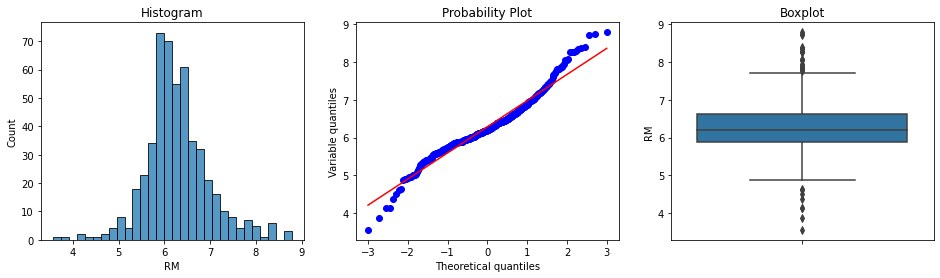

In [4]:
# tìm các outlier trong RM

diagnostic_plots(boston, 'RM')

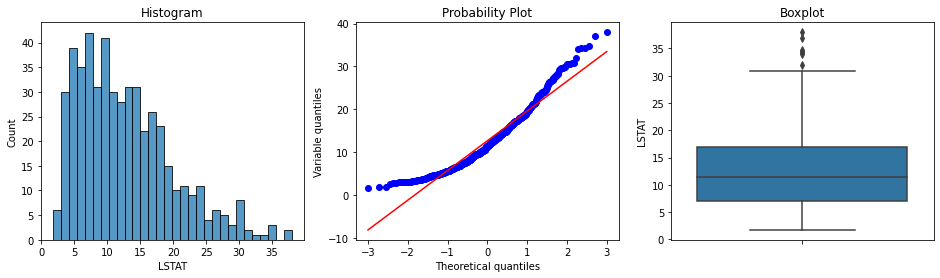

In [5]:
# hiển thị các outlier trong LSTAT

diagnostic_plots(boston, 'LSTAT')

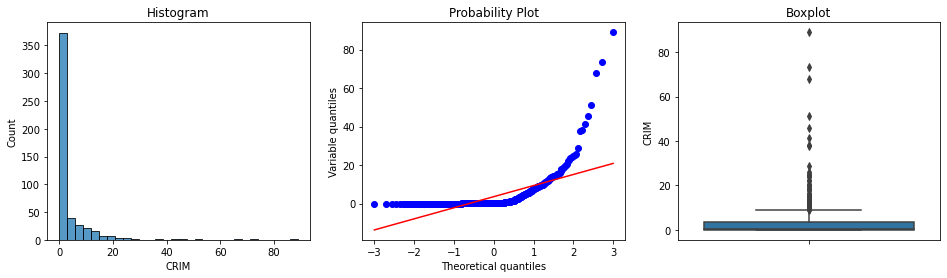

In [6]:
# các outlier trong CRIM

diagnostic_plots(boston, 'CRIM')

Tất cả các biến trên đều có outlier. RM hiển thị các outlier ở cả hai đầu, trong khi LSTAT và CRIM chỉ có ở phần đuôi bên phải.

Để tìm outlier, hãy sử dụng lại hàm chúng ta đã học:

## Quy tắc tiệm cận IQR 

In [7]:
## Yêu cầu 1
def find_skewed_boundaries(df, variable, distance):

    # tính các ranh giới bên ngoài có outlier
    # cho các phân phối lệch

    # truyền distance làm đối số, cho chúng ta lựa chọn
    # ước tính 1.5 * IQR hoặc 3 * IQR để tính
    # các ranh giới.

    ## VIẾT CODE Ở ĐÂY:
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    ## VIẾT CODE Ở ĐÂY:
    lower_boundary = df[variable].quantile(.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    ## VIẾT CODE Ở ĐÂY:
    return upper_boundary, lower_boundary

In [8]:
# tìm các giới hạn cho RM

RM_upper_limit, RM_lower_limit = find_skewed_boundaries(boston, 'RM', 1.5)
RM_upper_limit, RM_lower_limit

(7.730499999999999, 4.778500000000001)

In [9]:
# các giới hạn cho LSTAT

LSTAT_upper_limit, LSTAT_lower_limit = find_skewed_boundaries(boston, 'LSTAT', 1.5)
LSTAT_upper_limit, LSTAT_lower_limit

(31.962500000000006, -8.057500000000005)

In [10]:
# các giới hạn cho CRIM

CRIM_upper_limit, CRIM_lower_limit = find_skewed_boundaries(boston, 'CRIM', 1.5)
CRIM_upper_limit, CRIM_lower_limit

(9.06963875, -5.31051125)

In [11]:
## Yêu cầu 2
# thay thế các outlier bằng giới hạn max/min

## VIẾT CODE Ở ĐÂY:
boston['RM']= np.where(boston['RM'] > RM_upper_limit, RM_upper_limit,
                       np.where(boston['RM'] < RM_lower_limit, RM_lower_limit, boston['RM']))

In [12]:
## Yêu cầu 3
# thay thế các outlier bằng giới hạn max/min

## VIẾT CODE Ở ĐÂY:
boston['LSTAT']= np.where(boston['LSTAT'] > LSTAT_upper_limit, LSTAT_upper_limit,
                       np.where(boston['LSTAT'] < LSTAT_lower_limit, LSTAT_lower_limit, boston['LSTAT']))

In [13]:
## Yêu cầu 4
# thay thế các outlier bằng giới hạn max/min

## VIẾT CODE Ở ĐÂY:
boston['CRIM']= np.where(boston['CRIM'] > CRIM_upper_limit, CRIM_upper_limit,
                       np.where(boston['CRIM'] < CRIM_lower_limit, CRIM_lower_limit, boston['CRIM']))

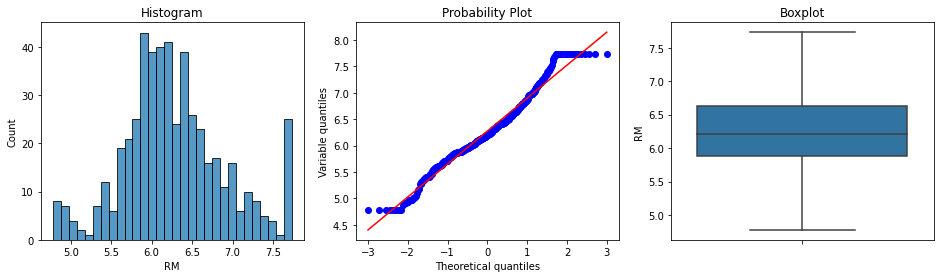

In [14]:
# khám phá các outlier trong tập dữ liệu đã cắt tỉa
# với RM, chúng ta thấy có ít outlier hơn so với tập dữ liệu gốc

diagnostic_plots(boston, 'RM')

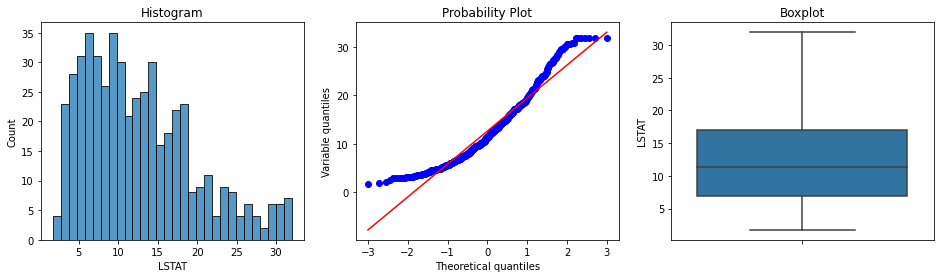

In [15]:
diagnostic_plots(boston, 'LSTAT')

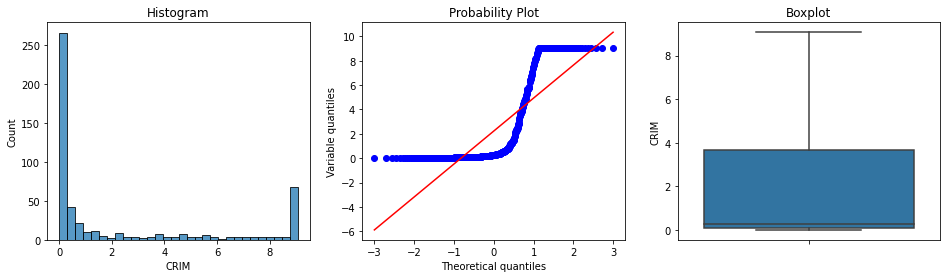

In [16]:
diagnostic_plots(boston, 'CRIM')

Các outlier đã biến mất nhưng phân phối biến bị sai lệch một ít.

### Censoring với Feature-engine

In [19]:
# load dữ liệu giá nhà ở Boston

# load tập dữ liệu boston từ sklearn
boston_dataset = load_boston()

# tạo một dataframe với các biến độc lập
# chúng ta sẽ chỉ sử dụng 3 trong tổng số các biến cho mô phỏng này

boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]

# thêm mục tiêu
boston['MEDV'] = boston_dataset.target

boston.head()

,RM,LSTAT,CRIM,MEDV
0,6.575,4.98,0.00632,24.0
1,6.421,9.14,0.02731,21.6
2,7.185,4.03,0.02729,34.7
3,6.998,2.94,0.03237,33.4
4,7.147,5.33,0.06905,36.2


In [20]:
# tạo giới hạn

windsoriser = Winsorizer(capping_method='iqr', # chọn iqr cho các ranh giới quy tắc IQR hoặc gaussian cho mean và std
                          tail='both', # giới hạn đuôi trái, phải hoặc cả 2 
                          fold=1.5,
                          variables=['RM', 'LSTAT', 'CRIM'])

windsoriser.fit(boston)

Winsorizer(capping_method='iqr', fold=1.5, tail='both',
           variables=['RM', 'LSTAT', 'CRIM'])

In [21]:
boston_t = windsoriser.transform(boston)

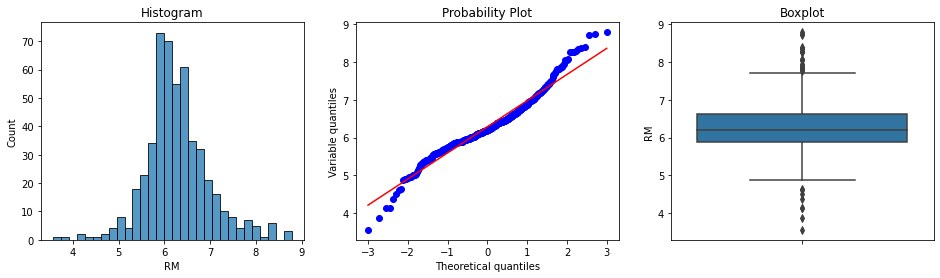

In [22]:
diagnostic_plots(boston, 'RM')

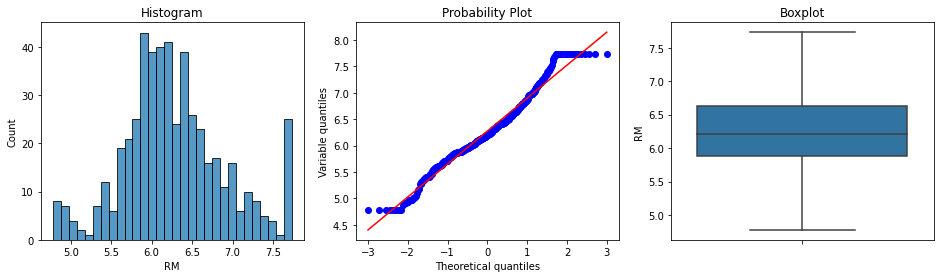

In [23]:
diagnostic_plots(boston_t, 'RM')

In [24]:
# kiểm tra các giới hạn tối thiểu cho từng biến
windsoriser.left_tail_caps_

{'RM': 4.778500000000001, 'LSTAT': -8.057500000000005, 'CRIM': -5.31051125}

In [25]:
# kiểm tra các giới hạn tối đa cho từng biến
windsoriser.right_tail_caps_

{'RM': 7.730499999999999, 'LSTAT': 31.962500000000006, 'CRIM': 9.06963875}

## Phép xấp xỉ Gauss

In [26]:
# load dữ liệu giá nhà ở Boston

# load tập dữ liệu boston từ sklearn
boston_dataset = load_boston()

# tạo một dataframe với các biến độc lập
# chúng ta sẽ chỉ sử dụng 3 trong tổng số các biến cho mô phỏng này

boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]

# thêm mục tiêu
boston['MEDV'] = boston_dataset.target

boston.head()

,RM,LSTAT,CRIM,MEDV
0,6.575,4.98,0.00632,24.0
1,6.421,9.14,0.02731,21.6
2,7.185,4.03,0.02729,34.7
3,6.998,2.94,0.03237,33.4
4,7.147,5.33,0.06905,36.2


In [38]:
## Yêu cầu 2
def find_normal_boundaries(df, variable, distance):

    # tính các ranh giới bên ngoài có outlier
    # cho phân phối gauss

    ## VIẾT CODE Ở ĐÂY:
    upper_boundary = df[variable].mean() + distance * df[variable].std()
    lower_boundary = df[variable].mean() - distance * df[variable].std()

    ## VIẾT CODE Ở ĐÂY:
    return upper_boundary, lower_boundary

In [39]:
# tìm các giới hạn cho RM

RM_upper_limit, RM_lower_limit = find_normal_boundaries(boston, 'RM', 3)
RM_upper_limit, RM_lower_limit

(8.352064576980858, 4.217085917480878)

In [40]:
# các giới hạn cho LSTAT

LSTAT_upper_limit, LSTAT_lower_limit = find_normal_boundaries(boston, 'LSTAT', 3)
LSTAT_upper_limit, LSTAT_lower_limit

(33.904798293890806, -8.630761776595294)

In [41]:
# các giới hạn cho CRIM

CRIM_upper_limit, CRIM_lower_limit = find_normal_boundaries(boston, 'CRIM', 3)
CRIM_upper_limit, CRIM_lower_limit

(21.335220816747928, -14.936278955141296)

In [42]:
# thay thế các outlier bằng giới hạn max/min

boston['RM']= np.where(boston['RM'] > RM_upper_limit, RM_upper_limit,
                       np.where(boston['RM'] < RM_lower_limit, RM_lower_limit, boston['RM']))

In [43]:
# thay thế các outlier bằng giới hạn max/min

boston['LSTAT']= np.where(boston['LSTAT'] > LSTAT_upper_limit, LSTAT_upper_limit,
                       np.where(boston['LSTAT'] < LSTAT_lower_limit, LSTAT_lower_limit, boston['LSTAT']))

In [44]:
# thay thế các outlier bằng giới hạn max/min

boston['CRIM']= np.where(boston['CRIM'] > CRIM_upper_limit, CRIM_upper_limit,
                       np.where(boston['CRIM'] < CRIM_lower_limit, CRIM_lower_limit, boston['CRIM']))

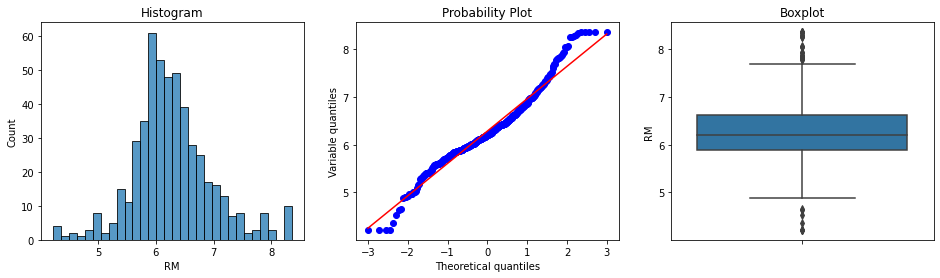

In [45]:
# khám phá các outlier trong tập dữ liệu đã cắt tỉa
# với RM, chúng ta thấy có ít outlier hơn so với tập dữ liệu gốc

diagnostic_plots(boston, 'RM')

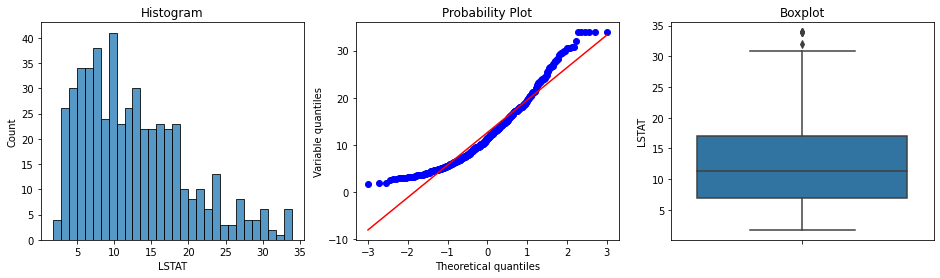

In [46]:
diagnostic_plots(boston, 'LSTAT')

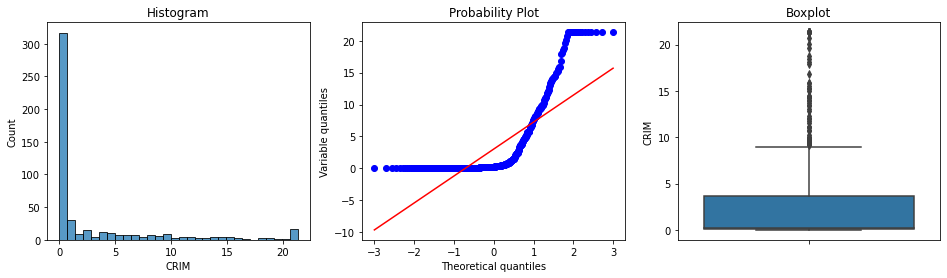

In [47]:
diagnostic_plots(boston, 'CRIM')

Không có biến nào trong số các biến này được phân phối chuẩn, có lẽ là do phép xấp xỉ Gauss không loại bỏ outlier hiệu quả. Chúng ta có thể thử sử dụng khoảng cách nhỏ hơn, thay vì nhân 3 với std, có thể nhân 2 hoặc 1.5. Các con số đó được thiết lập tùy ý và không có nhiều ý nghĩa thống kê nên bác bỏ quan điểm sử dụng phép xấp xỉ Gauss.

Nếu capping này không hoạt động như mong muốn, chúng ta nên sử dụng quy tắc IQR như đã thảo luận trong notebook trước hoặc quantile mà chúng ta sẽ thấy trong phần tiếp theo.

### Censoring với feature-engine

In [48]:
# load dữ liệu giá nhà ở Boston

# load tập dữ liệu boston từ sklearn
boston_dataset = load_boston()

# tạo một dataframe với các biến độc lập
# chúng ta sẽ chỉ sử dụng 3 trong tổng số các biến cho mô phỏng này

boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]

# thêm mục tiêu
boston['MEDV'] = boston_dataset.target

boston.head()

,RM,LSTAT,CRIM,MEDV
0,6.575,4.98,0.00632,24.0
1,6.421,9.14,0.02731,21.6
2,7.185,4.03,0.02729,34.7
3,6.998,2.94,0.03237,33.4
4,7.147,5.33,0.06905,36.2


In [49]:
# tạo giới hạn

windsoriser = Winsorizer(capping_method='gaussian', # chọn iqr cho các ranh giới quy tắc IQR hoặc gaussian cho mean và std 
                          tail='both', # giới hạn đuôi trái, phải hoặc cả 2
                          fold=3,
                          variables=['RM', 'LSTAT', 'CRIM'])

windsoriser.fit(boston)

Winsorizer(tail='both', variables=['RM', 'LSTAT', 'CRIM'])

In [50]:
boston_t = windsoriser.transform(boston)

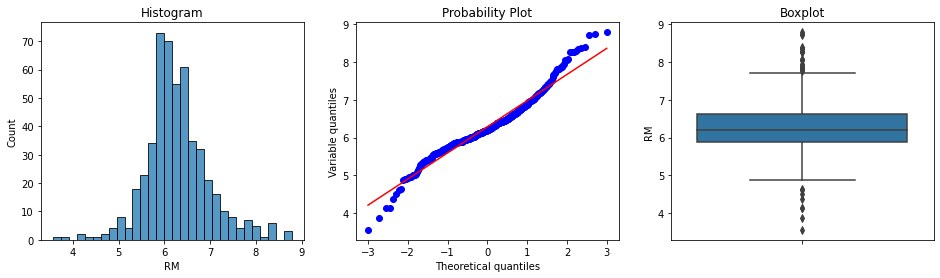

In [51]:
diagnostic_plots(boston, 'RM')

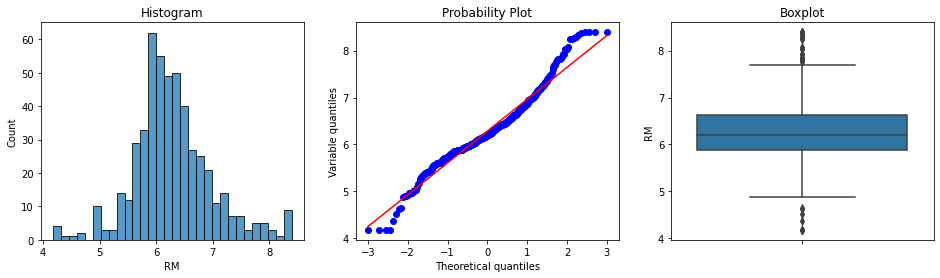

In [52]:
diagnostic_plots(boston_t, 'RM')

In [53]:
# kiểm tra các giới hạn tối thiểu cho từng biến
windsoriser.left_tail_caps_

{'RM': 4.176782957105816,
 'LSTAT': -8.77012129293899,
 'CRIM': -22.19111175868521}

In [54]:
# kiểm tra các giới hạn tối đa cho từng biến
windsoriser.right_tail_caps_

{'RM': 8.392485817597757,
 'LSTAT': 34.07624777515244,
 'CRIM': 29.418158873309714}

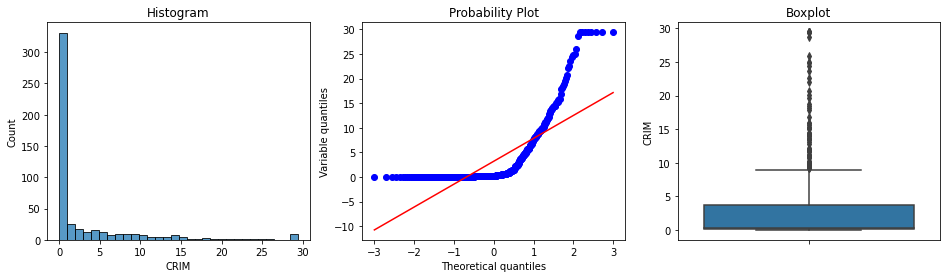

In [55]:
diagnostic_plots(boston_t, 'CRIM')

Không có biến nào trong số các biến này được phân phối chuẩn, có lẽ là do phép xấp xỉ Gauss không loại bỏ outlier hiệu quả. Chúng ta có thể thử sử dụng khoảng cách nhỏ hơn, thay vì nhân 3 với std, có thể nhân 2 hoặc 1.5. Các con số đó được thiết lập tùy ý và không có nhiều ý nghĩa thống kê nên bác bỏ quan điểm sử dụng phép xấp xỉ Gauss.

Nếu capping này không hoạt động như mong muốn, chúng ta nên sử dụng quy tắc IQR như đã thảo luận trong notebook trước hoặc quantile mà chúng ta sẽ thấy trong phần tiếp theo. 

## Quantile

In [56]:
# load dữ liệu giá nhà ở Boston

# load tập dữ liệu boston từ sklearn
boston_dataset = load_boston()

# tạo một dataframe với các biến độc lập
# chúng ta sẽ chỉ sử dụng 3 trong tổng số các biến cho mô phỏng này

boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]

# thêm mục tiêu
boston['MEDV'] = boston_dataset.target

boston.head()

,RM,LSTAT,CRIM,MEDV
0,6.575,4.98,0.00632,24.0
1,6.421,9.14,0.02731,21.6
2,7.185,4.03,0.02729,34.7
3,6.998,2.94,0.03237,33.4
4,7.147,5.33,0.06905,36.2


In [58]:
# Yêu cầu 3
def find_boundaries(df, variable):

    # ranh giới là quantile

    ## VIẾT CODE Ở ĐÂY:
    lower_boundary = df[variable].quantile(0.05)
    upper_boundary = df[variable].quantile(0.95)

    return upper_boundary, lower_boundary

In [59]:
# tìm các giới hạn cho RM

RM_upper_limit, RM_lower_limit = find_boundaries(boston, 'RM')
RM_upper_limit, RM_lower_limit

(7.5875, 5.314)

In [60]:
# các giới hạn cho LSTAT

LSTAT_upper_limit, LSTAT_lower_limit = find_boundaries(boston, 'LSTAT')
LSTAT_upper_limit, LSTAT_lower_limit

(26.8075, 3.7075000000000005)

In [61]:
# các giới hạn cho CRIM

CRIM_upper_limit, CRIM_lower_limit = find_boundaries(boston, 'CRIM')
CRIM_upper_limit, CRIM_lower_limit

(15.78915, 0.027909999999999997)

In [62]:
# thay các outlier bằng giới hạn max và min

boston['RM']= np.where(boston['RM'] > RM_upper_limit, RM_upper_limit,
                       np.where(boston['RM'] < RM_lower_limit, RM_lower_limit, boston['RM']))

In [63]:
# thay các outlier bằng giới hạn max và min

boston['LSTAT']= np.where(boston['LSTAT'] > LSTAT_upper_limit, LSTAT_upper_limit,
                       np.where(boston['LSTAT'] < LSTAT_lower_limit, LSTAT_lower_limit, boston['LSTAT']))

In [64]:
# thay các outlier bằng giới hạn max và min

boston['CRIM']= np.where(boston['CRIM'] > CRIM_upper_limit, CRIM_upper_limit,
                       np.where(boston['CRIM'] < CRIM_lower_limit, CRIM_lower_limit, boston['CRIM']))

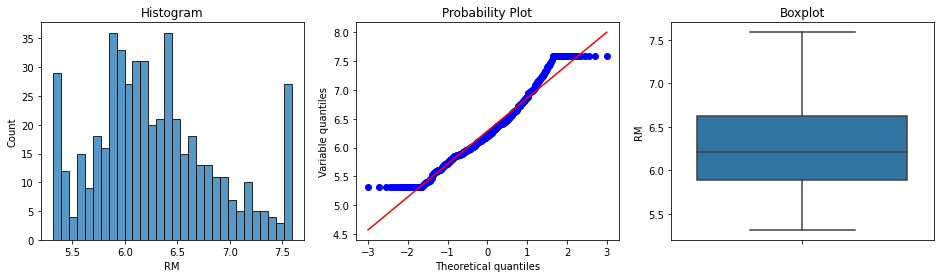

In [65]:
# khám phá các outlier trong tập dữ liệu đã cắt tỉa
# với RM, chúng ta thấy có ít outlier hơn so với tập dữ liệu gốc

diagnostic_plots(boston, 'RM')

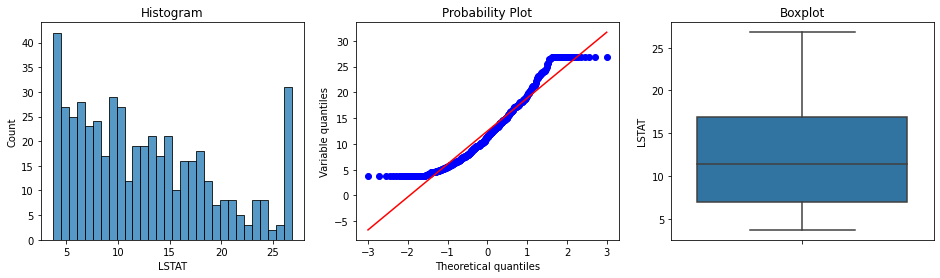

In [66]:
diagnostic_plots(boston, 'LSTAT')

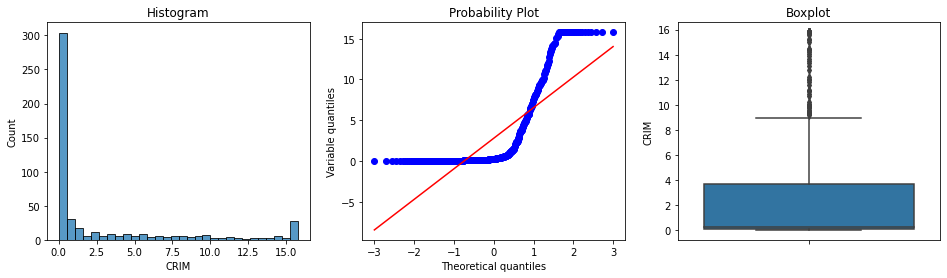

In [67]:
diagnostic_plots(boston, 'CRIM')

Các outlier đã biến mất nhưng phân phối biến bị sai lệch một ít.

### Censoring với feature-engine

In [68]:
# load dữ liệu giá nhà ở Boston

# load tập dữ liệu boston từ sklearn
boston_dataset = load_boston()

# tạo một dataframe với các biến độc lập
# chúng ta sẽ chỉ sử dụng 3 trong tổng số các biến cho mô phỏng này

boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]

# thêm mục tiêu
boston['MEDV'] = boston_dataset.target

boston.head()

,RM,LSTAT,CRIM,MEDV
0,6.575,4.98,0.00632,24.0
1,6.421,9.14,0.02731,21.6
2,7.185,4.03,0.02729,34.7
3,6.998,2.94,0.03237,33.4
4,7.147,5.33,0.06905,36.2


In [69]:
# tạo giới hạn

windsoriser = Winsorizer(capping_method='quantiles', # chọn từ iqr, gaussian hoặc quantiles
                          tail='both', # cap left, right or both tails giới hạn đuôi trái, phải hoặc cả 2
                          fold=0.05,
                          variables=['RM', 'LSTAT', 'CRIM'])

windsoriser.fit(boston)

Winsorizer(capping_method='quantiles', fold=0.05, tail='both',
           variables=['RM', 'LSTAT', 'CRIM'])

In [70]:
boston_t = windsoriser.transform(boston)

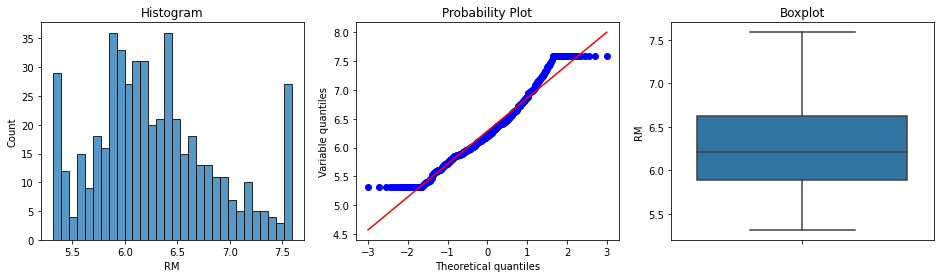

In [71]:
diagnostic_plots(boston_t, 'RM')

In [72]:
# kiểm tra các giới hạn tối thiểu cho từng biến
windsoriser.left_tail_caps_

{'RM': 5.314, 'LSTAT': 3.7075000000000005, 'CRIM': 0.027909999999999997}

In [73]:
# kiểm tra các giới hạn tối đa cho từng biến
windsoriser.right_tail_caps_

{'RM': 7.5875, 'LSTAT': 26.8075, 'CRIM': 15.78915}

## Giới hạn tùy ý

In [75]:
# hàm để load tập dữ liệu titanic

def load_titanic():
    data = pd.read_csv('./datatset/titanic.csv')
    data['cabin'] = data['cabin'].astype(str).str[0]
    data['pclass'] = data['pclass'].astype('O')
    data['embarked'].fillna('C', inplace=True)
    return data

In [76]:
data = load_titanic()
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### ArbitraryOutlierCapper

ArbitraryOutlierCapper giới hạn các giá trị min và max bằng một giá trị do người dùng xác định. 

In [77]:
# Yêu cầu 4
# tìm Age và Fare max trong titanic

## VIẾT CODE Ở ĐÂY:
data.age.max(), data.fare.max()

(80.0, 512.3292)

In [79]:
# Yêu cầu 5

## VIẾT CODE Ở ĐÂY:
capper = ArbitraryOutlierCapper(max_capping_dict={'age': 50, 'fare': 200},
                                min_capping_dict=None)
## VIẾT CODE Ở ĐÂY:
capper.fit(data.fillna(0))

ArbitraryOutlierCapper(max_capping_dict={'age': 50, 'fare': 200})

<details><summary> Gợi ý </summary>

[ArbitraryOutlierCapper()](https://feature-engine.readthedocs.io/en/latest/outliers/ArbitraryOutlierCapper.html)

</details>

In [80]:
capper.right_tail_caps_

{'age': 50, 'fare': 200}

In [81]:
capper.left_tail_caps_

{}

In [82]:
temp = capper.transform(data.fillna(0))

temp.age.max(), temp.fare.max()

(50.0, 200.0)

### Min capping

In [83]:
# Yêu cầu 6

## VIẾT CODE Ở ĐÂY:
capper = ArbitraryOutlierCapper(max_capping_dict=None,
                                min_capping_dict={
                                    'age': 10,
                                    'fare': 100
                                })
capper.fit(data.fillna(0))

ArbitraryOutlierCapper(min_capping_dict={'age': 10, 'fare': 100})

In [87]:
capper.variables_

['age', 'fare']

In [88]:
capper.right_tail_caps_

{}

In [89]:
capper.left_tail_caps_

{'age': 10, 'fare': 100}

In [90]:
temp = capper.transform(data.fillna(0))

temp.age.min(), temp.fare.min()

(10.0, 100.0)

### Giới hạn cả 2 đầu

In [92]:
# Yêu cầu 7
capper = ArbitraryOutlierCapper(max_capping_dict={
    'age': 50, 'fare': 200},
    min_capping_dict={
    'age': 10, 'fare': 100})

capper.fit(data.fillna(0))

ArbitraryOutlierCapper(max_capping_dict={'age': 50, 'fare': 200},
                       min_capping_dict={'age': 10, 'fare': 100})

In [93]:
capper.right_tail_caps_

{'age': 50, 'fare': 200}

In [94]:
capper.left_tail_caps_

{'age': 10, 'fare': 100}

In [95]:
temp = capper.transform(data.fillna(0))

temp.age.min(), temp.fare.min()

(10.0, 100.0)

In [96]:
temp.age.max(), temp.fare.max()

(50.0, 200.0)

## Feature-engine

Chúng ta có thể tự động hóa quá trình này với Feature-engine:
https://feature-engine.readthedocs.io/en/latest/outliers/ArbitraryOutlierCapper.html